<a href="https://colab.research.google.com/github/ikucherevsky/DeepLearning/blob/master/DL_for_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


1. Скачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
2. Обучить word2vec на фразах персонажей
3. Визуаилизировать embeddings по самым частотным словам (top 1000)
4. Найти самые близкие слова для:
  homer - marge + bart
  bart - lisa + school
  marge - homer + home
5.  попробовать построить классификатор bart/lisa с использованием этих эмбеддингов


## 1. Скачать датасет с фразами симпосонов - 
https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data

In [ ]:
!wget https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data/raw/master/simpsons_script_lines.csv.zip

--2020-04-30 16:59:51--  https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data/raw/master/simpsons_script_lines.csv.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sujanjoejacob/Text-mining-with-Simpsons-Data/master/simpsons_script_lines.csv.zip [following]
--2020-04-30 16:59:53--  https://raw.githubusercontent.com/sujanjoejacob/Text-mining-with-Simpsons-Data/master/simpsons_script_lines.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9163442 (8.7M) [application/zip]
Saving to: ‘simpsons_script_lines.csv.zip’

simpsons_script_lin 100%[===================>]   8.74M  18.3MB/s    i

In [ ]:
!unzip simpsons_script_lines.csv.zip

Archive:  simpsons_script_lines.csv.zip
  inflating: simpsons_script_lines.csv  


## 2. Обучить Word2Vec на фразах персонажей

In [ ]:
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import Counter
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
simpsons = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False)

b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'
b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line 153018: expected 13 fields, saw 30\nSkipping line 154080: expected 13 fields, saw 20\nSkipping line 154082: expected 13 fields, saw 20\nSkipping line 154084: expected 13 fields, saw 20\nSkipping line 154086: expected 13 fields, saw 20\n

In [ ]:
simpsons.dropna(inplace = True)

In [ ]:
simpsons.head(5)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


In [ ]:
simpsons = simpsons.sort_values(by = 'id')

In [ ]:
simpsons.tail()

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
147762,158303,568,193,Homer Simpson: I'm not leaving this casino unt...,1211000,true,2,4457.0,Homer Simpson,CASINO FLOOR,I'm not leaving this casino until you stop pun...,im not leaving this casino until you stop puni...,21.0
147766,158308,568,198,"Marge Simpson: Homie, after all this, do you s...",1227000,true,1,131.0,Marge Simpson,First Church of Springfield,"Homie, after all this, do you still believe in...",homie after all this do you still believe in god,10.0
147767,158309,568,199,Homer Simpson: On a beautiful night like tonig...,1230000,true,2,131.0,Homer Simpson,First Church of Springfield,On a beautiful night like tonight... how could...,on a beautiful night like tonight how could i not,10.0
147769,158311,568,201,"Lou: Next week on ""Sky Police"".",1292000,true,91,3.0,Lou,Springfield Elementary School,"Next week on ""Sky Police"".",next week on sky police,5.0
147773,158315,568,205,Chief Wiggum: Sky police!,1292000,true,71,585.0,Chief Wiggum,Warehouse District,Sky police!,sky police,2.0


In [ ]:
phrases = simpsons['normalized_text'].to_list()

In [ ]:
episodes = simpsons['episode_id'].unique()
len(episodes)

564

In [ ]:
# соединение списка фраз в один текст, без цифр
def phrases_to_text(phrases):
  text = ''
  number_digits = 0
  for i in range(len(phrases)):
    if not str(phrases[i]).isdigit():
      text += ' ' + str(phrases[i])
    else:
      number_digits += 1
  if number_digits != 0:
    print('Число удаленных цифр в тексте', number_digits)
  
  return text

In [ ]:
query = phrases_to_text(phrases)

Число удаленных цифр в тексте 10


In [ ]:
# исходная длина словаря
len(set(query.split()))

46773

Удалим редкие слова (встречаются 1 раз) из текста

In [ ]:
cnt = Counter(query.split())

In [ ]:
# список редких слов
rare_words = []
for key in cnt:
  if cnt[key] == 1:
    rare_words.append(key)

In [ ]:
rare_words = set(rare_words)
querywords = query.split()
resultwords  = [word for word in querywords if word not in rare_words]

In [ ]:
len(resultwords),len(rare_words)

(1279162, 22808)

In [ ]:
vocabulary = set(resultwords)
len(vocabulary)

23965

словарь сократился на **22808** слов

In [ ]:
w2i = {w: i for i, w in enumerate(vocabulary)}
i2w = {i: w for i, w in enumerate(vocabulary)}

In [ ]:
# здесь создается датасет для тренировки CBOW 
#  основная идея метода - выделение отдельных эпизодов, 
#как объединенных единым смыслом участков текста для создания правильного контекста
# context window size is four
def create_cbow_dataset(df, rare_words):
  episodes = df['episode_id'].unique()
  data = []
  for episode in episodes:
    ep_frame = df[df['episode_id'] == episode]
    ep_frame =  ep_frame.sort_values(by = 'id')
    episode_phrases = ep_frame['normalized_text'].to_list()
    text = phrases_to_text(episode_phrases)
    querywords = text.split()
    text  = [word for word in querywords if word not in rare_words]

    for i in range(4, len(text) - 4):
        context = [text[i - 4],text[i - 3], text[i - 2],text[i - 1],
                   text[i + 1], text[i + 2],text[i + 3], text[i + 4]]
        target = text[i]
        data.append((context, target))
  return data

In [ ]:
cbow_train = create_cbow_dataset(simpsons,rare_words)

Число удаленных цифр в тексте 5
Число удаленных цифр в тексте 1
Число удаленных цифр в тексте 1
Число удаленных цифр в тексте 1
Число удаленных цифр в тексте 1
Число удаленных цифр в тексте 1


In [ ]:
len(cbow_train)

1274650

In [ ]:
print('cbow sample', cbow_train[21112])

cbow sample (['oh', 'i', 'dont', 'want', 'trouble', 'you', 'not', 'at'], 'to')


In [ ]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((inputs.shape[0], -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out)
        return log_probs

In [ ]:
# подготовка массива для обучения
# превращение слов в контекст и таргет (Torch tensor ) из наборов  cbow_train
TRAIN = []
for context, target in cbow_train:
  ctx_idxs = [w2i[w] for w in context]
  ctx_idxs = torch.LongTensor(ctx_idxs)
  TRAIN.append((ctx_idxs,torch.LongTensor([w2i[target]])))


In [ ]:
TRAIN[4]

(tensor([20128,  7099,  3348, 17931,  6918, 21628,  8105,  5016]),
 tensor([6707]))

In [ ]:
len(TRAIN)

1274650

In [ ]:
BATCH_SIZE = 900
train_iter = torch.utils.data.DataLoader(TRAIN, batch_size=BATCH_SIZE, shuffle = True)

In [ ]:
embd_size = 300
learning_rate = 2.0
n_epoch = 50
vocab_size = len(vocabulary)
CONTEXT_SIZE = 4  # 4 words to the left, 4 to the right

hidden_size = 300
losses = []
loss_fn = nn.NLLLoss()
#model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
ep = [i for i in range(n_epoch)]
for epoch in ep:
    print(f'===========epoch=={epoch}===========')
    total_loss = .0
    for context, target in train_iter:
        context,target = context.cuda(), target.cuda()
        #print(context.shape)
        #context = context.unsqueeze(0)
        #print(context.shape)
        #print(target.shape)
        model.zero_grad()
        log_probs = model(context)
        #print('OUTPUT', log_probs.shape)
        target = target.squeeze()
        #print('TARGET',target.shape)
        loss = loss_fn(log_probs, target)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f'loss = {total_loss}')
    losses.append(total_loss)

===========epoch==0===========
loss = 4406.930023908615
===========epoch==1===========
loss = 4403.100372552872
===========epoch==2===========
loss = 4345.332688093185
===========epoch==3===========
loss = 4301.562513589859
===========epoch==4===========
loss = 4259.8434863090515
===========epoch==5===========
loss = 4225.051831245422
===========epoch==6===========
loss = 4191.900539398193
===========epoch==7===========
loss = 4162.972436666489
===========epoch==8===========
loss = 4135.511107683182
===========epoch==9===========
loss = 4107.411483764648
===========epoch==10===========
loss = 4082.625952720642
===========epoch==11===========
loss = 4055.9252395629883
===========epoch==12===========
loss = 4033.2178032398224
===========epoch==13===========
loss = 4013.185335636139
===========epoch==14===========
loss = 3991.2195901870728
===========epoch==15===========
loss = 3961.924654006958
===========epoch==16===========
loss = 3941.789987564087
===========epoch==17===========
loss 

In [ ]:
sample_to_test = [cbow_train[random.randint(1,len(cbow_train))] for i in range(900)]

In [ ]:
model.cpu()

CBOW(
  (embeddings): Embedding(23965, 300)
  (linear1): Linear(in_features=2400, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=23965, bias=True)
)

In [ ]:
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))
        ctx_var = ctx_var.unsqueeze(0)
        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted.item()]
        if predicted_word == target:
            correct_ct += 1
        print('label :', target)
        print('predicted:', predicted_word)
             
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [ ]:
test_cbow(sample_to_test,model)

====Test CBOW===
label : whole
predicted: whole
label : lisa
predicted: burns
label : bed
predicted: bed
label : and
predicted: and
label : dont
predicted: dont
label : i
predicted: i
label : his
predicted: the
label : person
predicted: person
label : and
predicted: and
label : hes
predicted: look
label : in
predicted: there
label : read
predicted: had
label : there
predicted: there
label : after
predicted: after
label : be
predicted: be
label : say
predicted: from
label : not
predicted: not
label : the
predicted: the
label : ba
predicted: ba
label : and
predicted: it
label : take
predicted: just
label : is
predicted: was
label : very
predicted: very
label : --
predicted: and
label : flanders
predicted: that
label : may
predicted: if
label : mean
predicted: mean
label : man
predicted: man
label : brooks
predicted: the
label : could
predicted: yeah
label : nice
predicted: old
label : here
predicted: here
label : miss
predicted: think
label : the
predicted: the
label : her
predicted: my


<Figure size 432x288 with 0 Axes>

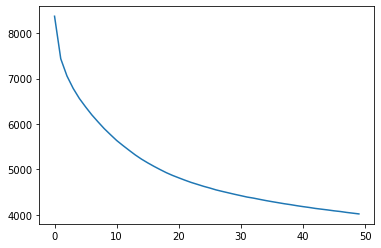

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(losses, 'CBOW Losses')

## 3. Визуаилизировать embeddings по самым частотным словам (top 1000)

In [ ]:
from gensim.models import Word2Vec
from collections import Counter
from sklearn.decomposition import PCA
from pylab import rcParams
rcParams['figure.figsize'] = 20,12

In [ ]:
phrases = simpsons['normalized_text'].to_list()

In [ ]:
sentences = []
for phrase in phrases:
  phrase_words = [word for word in phrase.split() if word not in rare_words]
  sentences.append(phrase_words)

In [ ]:
sentences[:4]

[['ooo', 'careful', 'homer'],
 ['theres', 'no', 'time', 'to', 'be', 'careful'],
 ['were', 'late'],
 ['sorry', 'excuse', 'us', 'pardon', 'me']]

In [ ]:
# train model
model = Word2Vec(sentences, min_count=2)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
#print(words)
# access vector for one word
print(model['sentence'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec(vocab=23965, size=100, alpha=0.025)
[ 0.19187653 -0.02780551 -0.08775675 -0.16496415  0.06572865 -0.05648259
  0.16444778 -0.14157324  0.06952123  0.01580678  0.01965329 -0.22194262
 -0.10418399  0.19380827 -0.0355412  -0.10046209  0.01910257 -0.04601309
  0.07138101  0.1752598  -0.14821567  0.02988209  0.15708616 -0.36030525
  0.34302503  0.12628923 -0.04323106  0.25646648  0.09864267 -0.1967225
 -0.18954755  0.10338127  0.09273186  0.06088593 -0.0373153   0.06499185
 -0.06941667  0.1217277  -0.10246938 -0.00212437  0.07556888  0.20247239
 -0.0213081  -0.11104961 -0.22388676 -0.20077169  0.06680748  0.08143291
 -0.1917518  -0.06892356  0.09751672 -0.0497806  -0.35245878  0.22019395
  0.17365663  0.1538738   0.18069005  0.11496758  0.20324141  0.01425936
 -0.19999446 -0.03324458 -0.05897698 -0.0016161   0.09843589 -0.02072638
  0.2035541   0.11954489  0.07784925 -0.295598   -0.18942207 -0.15711853
  0.07980965 -0.14992635 -0.41724545 -0.02201702 -0.00592475  0.18053617
 -0.239

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Word2Vec(vocab=23965, size=100, alpha=0.025)


In [ ]:
def plot_most_common_word(df,model,rare_words,n = 100):
  phrases = df['normalized_text'].to_list()
  text = phrases_to_text(phrases)
  querywords = text.split()
  resultwords  = [word for word in querywords if word not in rare_words]
  cntr = Counter(resultwords)
  top_n = cntr.most_common(n)
  most_common = []

  for word,count in top_n:
    most_common.append(word)
  
  X = model[most_common]

  pca = PCA(n_components=2)
  result = pca.fit_transform(X)
  plt.scatter(result[:, 0], result[:, 1])
  words = most_common
  for i, word in enumerate(words):
	  plt.annotate(word, xy=(result[i, 0], result[i, 1]))
  plt.show()

In [ ]:
rcParams['figure.figsize'] = 16,10

Число удаленных цифр в тексте 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


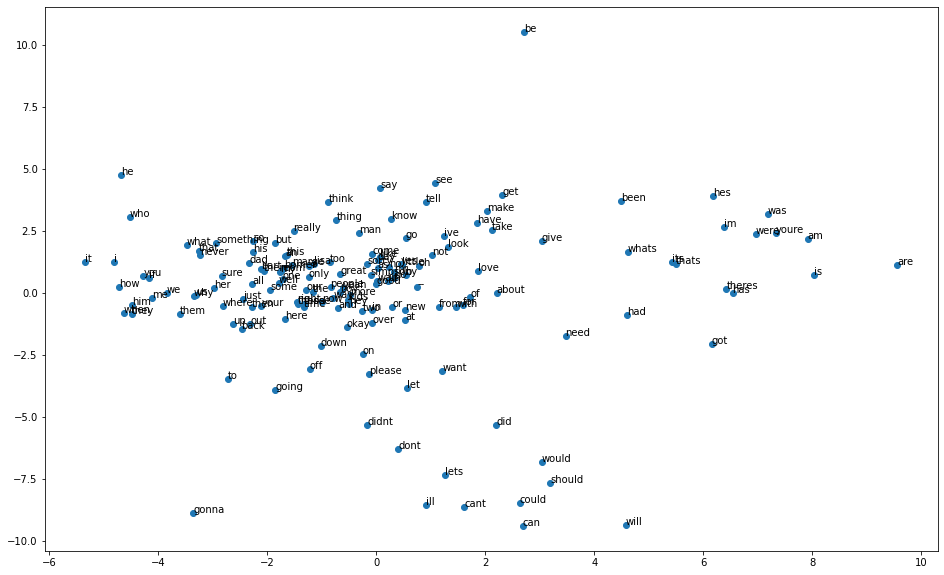

In [ ]:
plot_most_common_word(simpsons,model,rare_words,n=150)

Число удаленных цифр в тексте 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


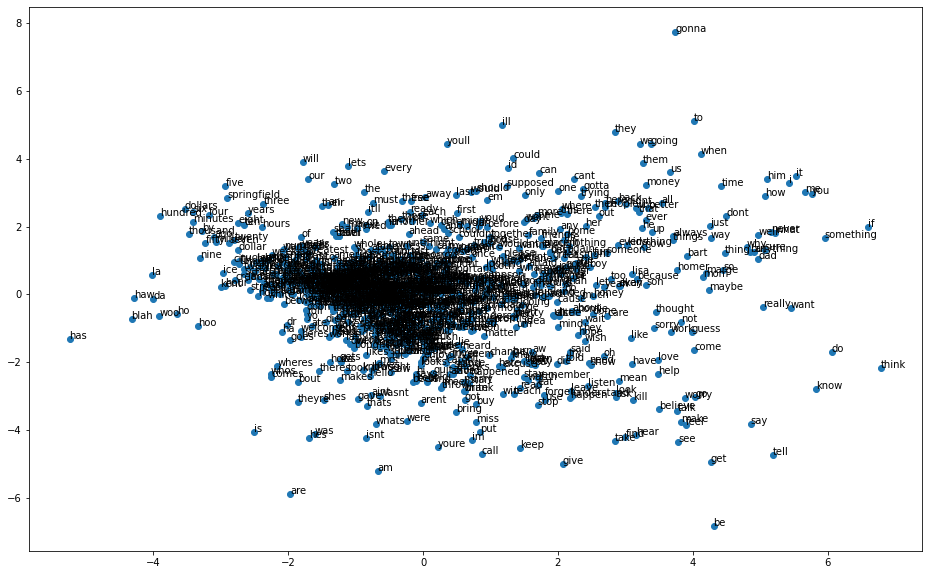

In [ ]:
plot_most_common_word(simpsons,model,rare_words,n=1000)

##4. Найти самые близкие слова для:
  homer - marge + bart

  bart - lisa + school
  
  marge - homer + home

In [ ]:
new_model

In [ ]:
# calculate: homer - marge + bart
result = new_model.most_similar(positive=['homer', 'bart'], negative=['marge'], topn=5)
print(result)

[('lisa', 0.8024460077285767), ('grampa', 0.6647453308105469), ('milhouse', 0.6383002996444702), ('eliza', 0.6337747573852539), ('mrs', 0.624794602394104)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
# calculate: bart - lisa + school
result = new_model.most_similar(positive=['school', 'bart'], negative=['lisa'], topn=5)
print(result)

[('church', 0.7474527955055237), ('house', 0.7182285785675049), ('game', 0.7153236269950867), ('store', 0.7109593152999878), ('bar', 0.6965290307998657)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
# calculate: marge - homer + home
result = new_model.most_similar(positive=['marge', 'home'], negative=['homer'], topn=5)
print(result)

[('back', 0.7668092846870422), ('bed', 0.7292125225067139), ('sleep', 0.6890376806259155), ('dinner', 0.610815167427063), ('together', 0.6093399524688721)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## 5. Классификатор Bart/Lisa

In [ ]:
import math
import numpy as np

In [ ]:
new_model

In [ ]:
model['marge']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.46331134, -0.5492639 ,  0.07352135,  0.39987275,  0.48220545,
        0.8756199 ,  0.67891943,  0.08464141,  0.82347584, -0.44032222,
        0.20708351, -0.22382677,  0.3858224 ,  1.4110447 ,  0.69569343,
       -0.6435458 , -0.6182126 ,  1.1868736 ,  0.04579272,  0.0525138 ,
        0.31911603, -0.5570318 ,  0.8616589 ,  0.6018608 , -0.32873377,
        1.4905604 , -0.02909339,  0.0828516 , -1.3264644 , -1.1121719 ,
       -0.32704383,  0.68848443,  0.7794684 , -0.97439766,  1.0242205 ,
        0.5190699 , -2.3618836 ,  0.7142125 , -0.83131886, -0.1712428 ,
       -0.57103735,  0.3020218 , -0.5157668 ,  0.4845257 , -0.28919408,
       -0.07948983, -0.66349286, -0.51929146, -0.37278992,  0.70481306,
        0.8809485 ,  1.0066521 ,  0.5027569 ,  0.2653406 ,  0.36093548,
        1.2086108 ,  0.40970728,  0.27956152,  1.6560714 , -0.46203995,
       -1.1904888 ,  0.39672175,  0.1742324 , -0.18047456,  0.9143269 ,
       -0.21935266, -0.8624584 ,  0.25460538,  0.47351575, -1.91

In [ ]:
def length(v):
  return math.sqrt(np.dot(v, v))

def cos_vectors(v1, v2):
  return np.dot(v1,v2) / (length(v1) * length(v2))

In [ ]:
def bart_lisa_classificator(word2classificate,model):
  word_vector = model[word2classificate]
  bart_vector = model['bart']
  lisa_vector = model['lisa']
  bart_cos = cos_vectors(bart_vector,word_vector)
  lisa_cos = cos_vectors(lisa_vector,word_vector)
  bart_cos = round(bart_cos,3)
  lisa_cos = round(lisa_cos,3)
  if bart_cos > lisa_cos:
    print('This is Bart')
  elif lisa_cos > bart_cos:
    print('This is Lisa')
  else:
    print('The word  belongs both Bart and Lisa ')
  print('COS  for Bart', bart_cos)
  print('COS for Lisa', lisa_cos)
  return

In [ ]:
bart_lisa_classificator('game',model)

This is Bart
COS  for Bart 0.405
COS for Lisa 0.331


In [ ]:
bart_lisa_classificator('music',model)

This is Lisa
COS  for Bart 0.279
COS for Lisa 0.29


In [ ]:
bart_lisa_classificator('jazz',model)

This is Lisa
COS  for Bart 0.145
COS for Lisa 0.208
